# Bayesian Linear Regression
Based on the Seoul Bike Sharing Demand dataset located at ../data/SeoulBikeData.csv
Load the data and split into train and test sets, 80% for training and 20% for testing.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import pymc as pm
import arviz as az

In [75]:
file_path = '../data/SeoulBikeData.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
numeric_season = {'Spring' : 1, 'Summer' : 2, 'Autumn' : 3, 'Winter' : 4}
numeric_holiday = {'No Holiday' : 0, 'Holiday' : 1}
numeric_functioning_day = {'No' : 0, 'Yes' : 1}
df['Seasons'] = df['Seasons'].map(numeric_season)
df['Holiday'] = df['Holiday'].map(numeric_holiday)
df['Functioning Day'] = df['Functioning Day'].map(numeric_functioning_day)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
print(df.shape)
print(df.head())
X = df.drop(['Rented Bike Count'], axis=1)
y = df['Rented Bike Count']

(8760, 17)
        Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0 2017-12-01                254     0             -5.2           37   
1 2017-12-01                204     1             -5.5           38   
2 2017-12-01                173     2             -6.0           39   
3 2017-12-01                107     3             -6.2           40   
4 2017-12-01                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  \
0                      0.0           0.0            0.0        4        0   

In [76]:
# process the data
X_np = X.to_numpy(dtype=np.float32)
y_np = y.to_numpy(dtype=np.float32)
print(X_np.shape)
print(y_np.shape)
print("X_train dtype:", X_np.dtype)
print("y_train dtype:", y_np.dtype)

binary_columns_indices = [i for i, col in enumerate(X.columns) if len(np.unique(X_np[:, i])) == 2]
X_scaled = X_np.copy()

X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print(y_train.shape)
print(y_test.shape)

Training set size: (7008, 16)
Test set size: (1752, 16)
(7008,)
(1752,)


In [ ]:
with pm.Model() as model:
    # Priors for regression coefficients
    # Use 'sigma' instead of 'sd' for the standard deviation
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])

    # Precision of the model (inverse of the variance)
    # Gamma distribution for the precision of the error term
    tau = pm.Gamma('tau', alpha=1, beta=1)

    # Intercept
    # Normal distribution for the intercept
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Expected value of outcome (linear model)
    mu = alpha + pm.math.dot(X_train, beta)

    # Likelihood (sampling distribution) of observations
    # Normal distribution for the likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=1/tau, observed=y_train)

    # Draw posterior samples
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

# Generate summary statistics
summary = az.summary(trace)
print(summary)

with pm.Model() as model:
    # 回归系数的先验
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])

    # 截距的先验
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # 模型误差的标准差的先验（使用 HalfCauchy 分布是一种常见选择）
    sigma = pm.HalfCauchy('sigma', beta=10)

    # 线性模型的期望值
    mu = alpha + tt.dot(X_train, beta)

    # 观测值的似然
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)

    # 调整采样参数来改善采样过程
    trace = pm.sample(1000, tune=2000, target_accept=0.95, return_inferencedata=True)

# 生成摘要统计
summary = az.summary(trace)
print(summary)

E:\envis\Anaconda3\envs\ml_env\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (72) in plot_autocorr, generating only 40 plots
  warnings.warn(


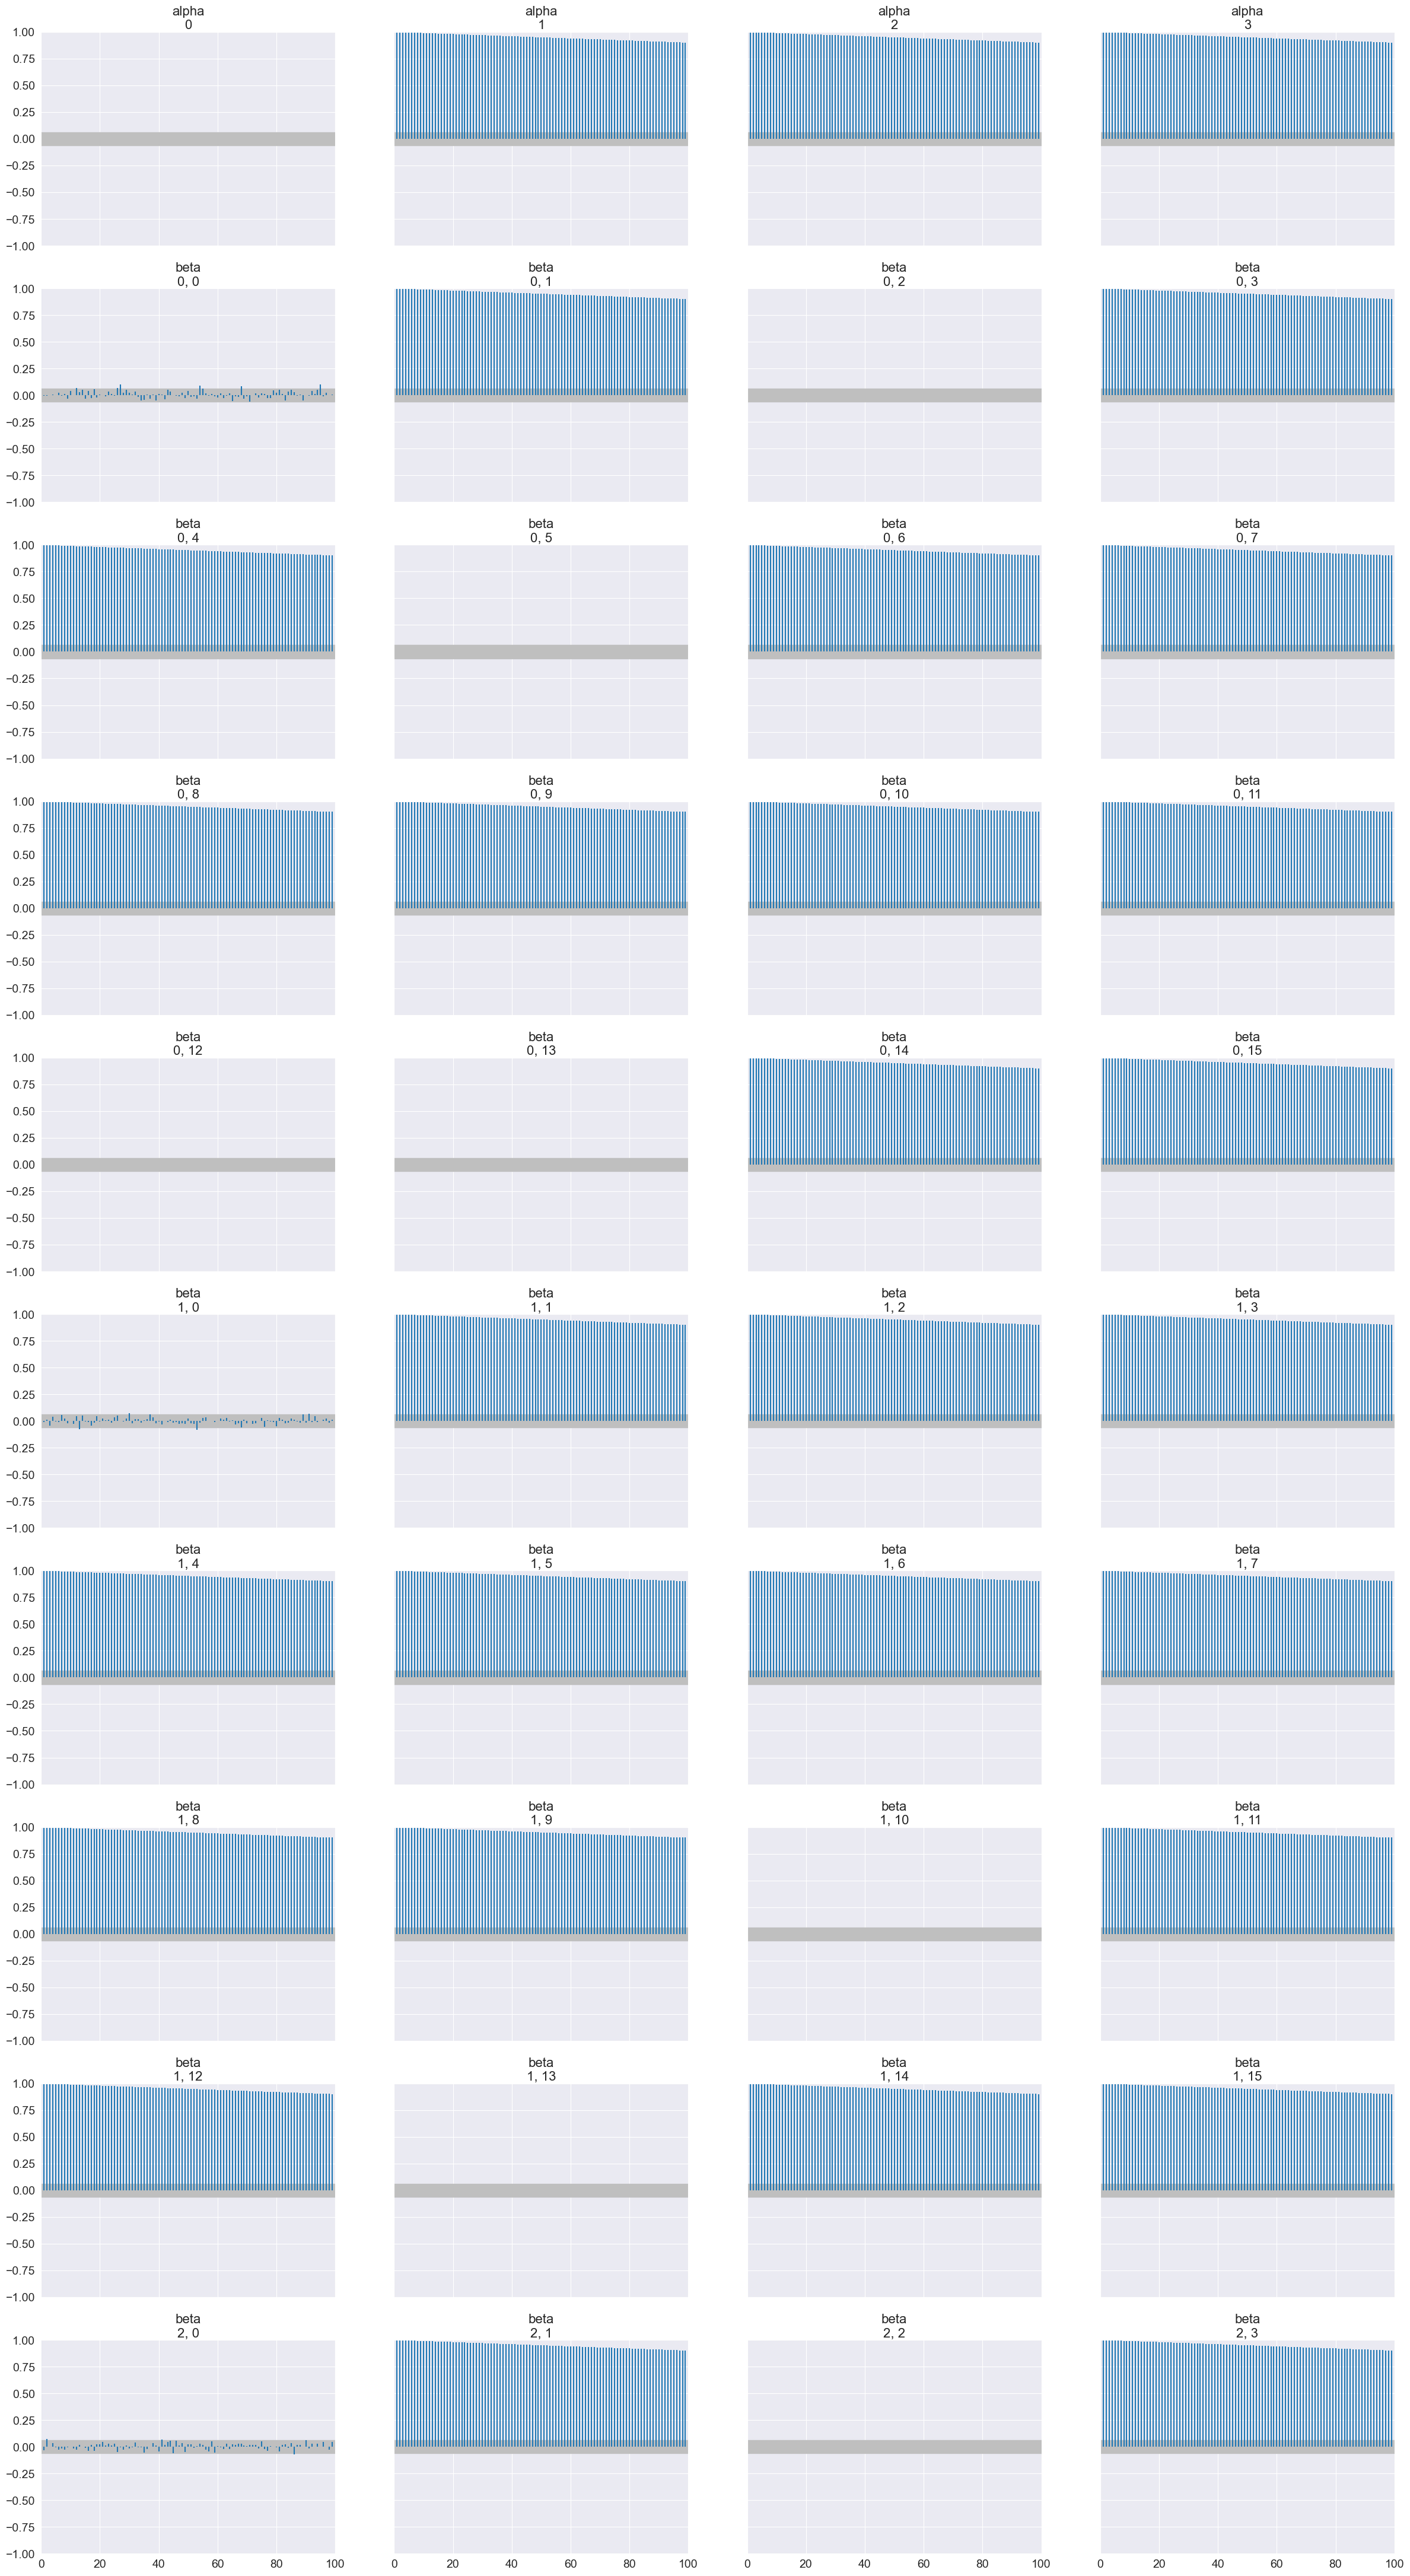

In [74]:
az.plot_autocorr(trace, var_names=['alpha', 'beta', 'tau'])
plt.show()